# Tuning and Optimizing Neural Networks - Lab

## Introduction

Now that we've discussed some regularization, initialization and optimization techniques, its time to synthesize those concepts into a cohesive modelling pipeline.  

With this pipeline, yoiu will not only fit an initial model but will also attempt to set various hyperparameters for regularization techniques. Your final model selection will pertain to the test metrics across these models. This will more naturally simulate a problem you might be faced with in practice, and the various modelling decisions you are apt to encounter along the way.  

Recall that our end objective is to achieve a balance between overfitting and underfitting. We've discussed the bias variance tradeoff, and the role of regularization in order to reduce overfitting on training data and improving generalization to new cases. Common frameworks for such a procedure include train/validate/test methodology when data is plentiful, and K-folds cross-validation for smaller, more limited datasets. In this lab, you'll perform the latter, as the dataset in question is fairly limited. 

## Objectives

You will be able to:

* Implement a K-folds cross validation modelling pipeline
* Apply normalization as a preprocessing technique
* Apply regularization techniques to improve your model's generalization
* Choose an appropriate optimization strategy 

## Loading the Data

In [1]:
#Your code here; load and preview the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('loan_final.csv',header=0)
df = df.dropna()
df.head()

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,total_acc,total_pymnt,application_type
0,5000.0,4975.0,36 months,10.65%,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,AZ,9.0,5863.155187,Individual
1,2500.0,2500.0,60 months,15.27%,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,GA,4.0,1014.530000,Individual
2,2400.0,2400.0,36 months,15.96%,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,IL,10.0,3005.666844,Individual
3,10000.0,10000.0,36 months,13.49%,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,CA,37.0,12231.890000,Individual
4,3000.0,3000.0,60 months,12.69%,67.79,B,1 year,RENT,80000.0,Source Verified,Fully Paid,other,OR,38.0,4066.908161,Individual


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41394 entries, 0 to 42516
Data columns (total 16 columns):
loan_amnt              41394 non-null float64
funded_amnt_inv        41394 non-null float64
term                   41394 non-null object
int_rate               41394 non-null object
installment            41394 non-null float64
grade                  41394 non-null object
emp_length             41394 non-null object
home_ownership         41394 non-null object
annual_inc             41394 non-null float64
verification_status    41394 non-null object
loan_status            41394 non-null object
purpose                41394 non-null object
addr_state             41394 non-null object
total_acc              41394 non-null float64
total_pymnt            41394 non-null float64
application_type       41394 non-null object
dtypes: float64(6), object(10)
memory usage: 5.4+ MB


## Defining the Problem

Set up the problem by defining X and Y. 

For this problem use the following variables for X:
* loan_amnt
* home_ownership
* funded_amnt_inv
* verification_status
* emp_length
* installment
* annual_inc

Be sure to use dummy variables for categorical variables and to normalize numerical quanitities. Be sure to also remove any rows with null data.  

For Y, we are looking to build a model to predict the total payment received for a loan.

In [6]:
# Your code here; appropriately define X and Y using dummy variables and normalization for preprocessing.
X = df[['loan_amnt','home_ownership','funded_amnt_inv','verification_status','emp_length','installment','annual_inc']]
Y = df['total_pymnt']

In [7]:
cont = ['loan_amnt','funded_amnt_inv','installment','annual_inc']
for var in cont:
    X[var] = (X[var]-np.mean(X[var]))/np.std(X[var])
xhomeown = pd.get_dummies(X['home_ownership'])
xverstat = pd.get_dummies(X['verification_status'])
xemplen = pd.get_dummies(X['emp_length'])
X = pd.concat([X,xhomeown,xverstat,xemplen],axis=1)
X.drop(['home_ownership','verification_status','emp_length'],axis=1,inplace=True)
X.head()

Y = (Y-np.mean(Y))/np.std(Y)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Generating a Hold Out Test Set

While we will be using K-fold cross validation to select an optimal model, we still want a final hold out test set that is completely independent of any modelling decisions. As such, pull out a sample of 10% of the total available data. For consistency of results, use random seed 123. 

In [8]:
# Your code here; generate a hold out test set for final model evaluation. Use random seed 123.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=123)  

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.head()

(37254, 23) (4140, 23) (37254,) (4140,)


,loan_amnt,funded_amnt_inv,installment,annual_inc,MORTGAGE,NONE,OTHER,OWN,RENT,Not Verified,...,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
24882,0.112849,0.021326,-0.286460,0.189661,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5723,-0.669251,-0.559691,-0.587677,-0.151157,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
32465,0.841010,1.008356,1.374322,0.468512,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
34510,-0.831064,-0.727696,-0.806909,-0.306075,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
9396,0.921917,1.092359,1.162835,0.158677,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


## Defining a K-fold Cross Validation Methodology

Now that your have a complete holdout test set, write a function that takes in the remaining data and performs k-folds cross validation given a model object. Be sure your function returns performance metrics regarding the training and validation sets.

In [9]:
#Your code here; define a function to evaluate a model object using K folds cross validation.
from sklearn.model_selection import KFold
import seaborn as sns

def k_folds(features_train, labels_train, model_obj, k=10, n_epochs=100):
    colors = sns.color_palette("Set2")

    validation_scores = [] 
    
    kf = KFold(n_splits=10, shuffle=True)
    
    fig, axes = plt.subplots(2, 5, figsize=(12,8))
    for i, (train_index, test_index) in enumerate(kf.split(features_train)):
        "Currently graph imaging assumes 10 folds and is hardcoded to 5x2 layout."
        row = i//5
        col = i%5
        X_train, X_val = features_train.iloc[train_index], features_train.iloc[test_index]
        y_train, y_val = labels_train.iloc[train_index], labels_train.iloc[test_index]
        
        model = model_obj
        hist = model.fit(X_train, y_train, batch_size=32,
                         epochs=n_epochs, verbose=0, validation_data = (X_val, y_val))
        #Note: verboxe=0 turns off printouts regarding training for each epoch.
        #Potential simpler methodology
        validation_score = model.evaluate(X_val, y_val)
        validation_scores.append(validation_score)
        ax = axes[row, col]
        k = 'val_loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[0])

        k = 'loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[1])
        ax.set_title('Fold {} Validation'.format(i+1))
    #Final Graph Formatting
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.legend(bbox_to_anchor=(1,1))
    
    #General Overview
    validation_score = np.average(validation_scores)
    print('Mean Validation Score:', validation_score)
    print('Standard Deviation of Validation Scores:', np.std(validation_scores))
    return validation_score

## Building a Baseline Model

Here, it is also important to define your evaluation metric that you will look to optimize while tuning the model.   

In general, model training to optimize this metric may consist of using a validation and test set if data is plentiful, or k-folds cross-validation if data is limited. We set up a k-folds cross-validation for this task since the dataset is not overly large.  

Build an initial sequential model with 2 hidden relu layers. The first should have 7 hidden units, and the second 10 hidden units. Finally, add a third layer with a linear activation function to output our predictions for the total loan payment. 

In [10]:
#Your code here; define and compile an initial model as described
from keras.models import Sequential
from keras.layers import Dense
np.random.seed(123)
model = Sequential()
model.add(Dense(7, activation='relu', input_dim=23, kernel_initializer='normal'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(optimizer='sgd',loss='mse',metrics=['mse'])

Using TensorFlow backend.
W0807 15:16:09.239145 140736270398336 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 15:16:09.276528 140736270398336 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 15:16:09.286019 140736270398336 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0807 15:16:09.313709 140736270398336 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 15:16:09.346216 14073

## Evaluating the Baseline Model with K-Folds Cross Validation

Use your k-folds function to evaluate the baseline model.  

Note: This code block is likely to take 10-20 minutes to run depending on the specs on your computer.
Because of time dependencies, it can be interesting to begin timing these operations for future reference.

Here's a simple little recipe to achieve this:
```
import time
import datetime

now = datetime.datetime.now()
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)
```

W0807 15:16:17.226765 140736270398336 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



3725/3725 [==============================] - 0s 17us/step
Mean Validation Score: 0.18774624977005838
Standard Deviation of Validation Scores: 0.014149685419471569
Time Elapsed: 0:20:05.906141


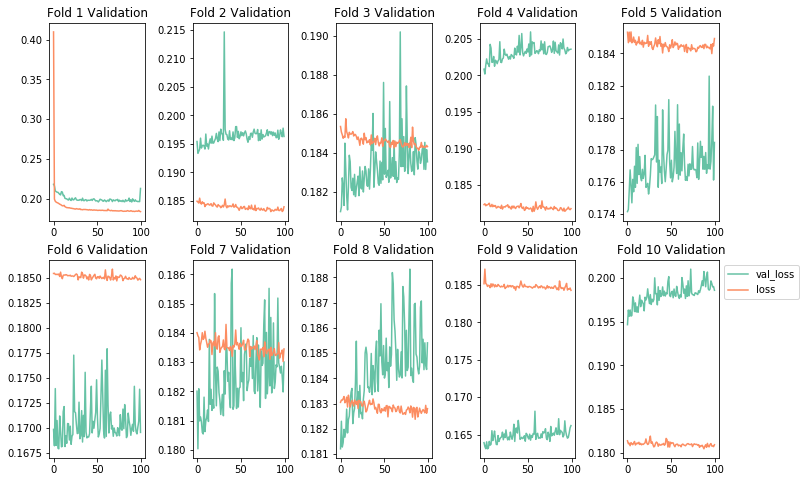

In [11]:
#Your code here; use your k-folds function to evaluate the baseline model.
import time
import datetime

now = datetime.datetime.now()

k_folds(X_train, y_train, model)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

## Intentionally Overfitting a Model

Now that you've developed a baseline model, its time to intentionally overfit a model. To overfit a model, you can:
* Add layers
* Make the layers bigger
* Increase the number of training epochs

Again, be careful here. Think about the limitations of your resources, both in terms of your computers specs and how much time and patience you have to let the process run. Also keep in mind that you will then be regularizing these overfit models, meaning another round of experiments and more time and resources.  

For example, here are some timing notes on potential experiments run on a Macbook Pro 3.1 GHz Intel Core i5 with 16gb of RAM:

* Using our 10 fold cross validation methodology, a 5-layer neural network with 10 units per hidden layer and 100 epochs took approximately 15 minutes to train and validate  

* Using our 10 fold cross validation methodology, a 5-layer neural network with 25 units per hidden layer and 100 epochs took approximately 25 minutes to train and validate  

* Using our 10 fold cross validation methodology, a 5-layer neural network with 10 units per hidden layer and 250 epochs took approximately 45 minutes to train and validate


3725/3725 [==============================] - 0s 19us/step
Mean Validation Score: 0.18587479651012728
Standard Deviation of Validation Scores: 0.00933450519320975
Time Elapsed: 0:20:11.607525


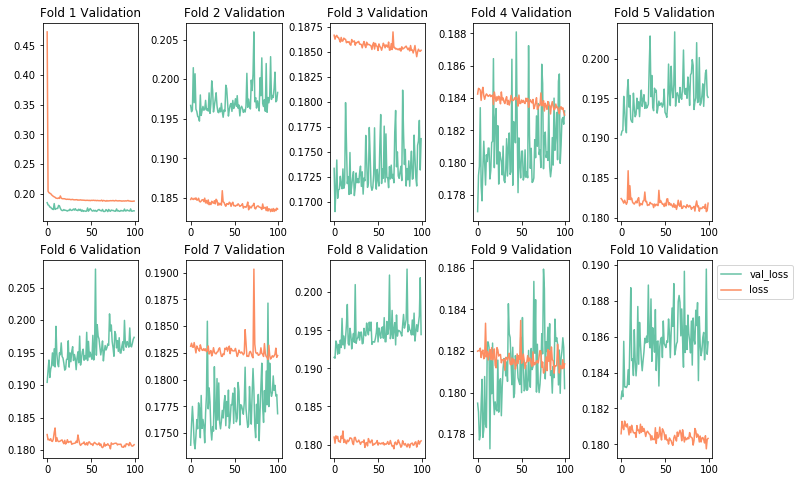

In [12]:
#Your code here; try some methods to overfit your network
now = datetime.datetime.now()

model = Sequential()
model.add(Dense(7, activation='relu', input_dim=23, kernel_initializer='normal'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(optimizer='sgd',loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model)    

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3725/3725 [==============================] - 0s 18us/step
Mean Validation Score: 0.1869329284068318
Standard Deviation of Validation Scores: 0.0112670558390746
Time Elapsed: 0:17:48.291283


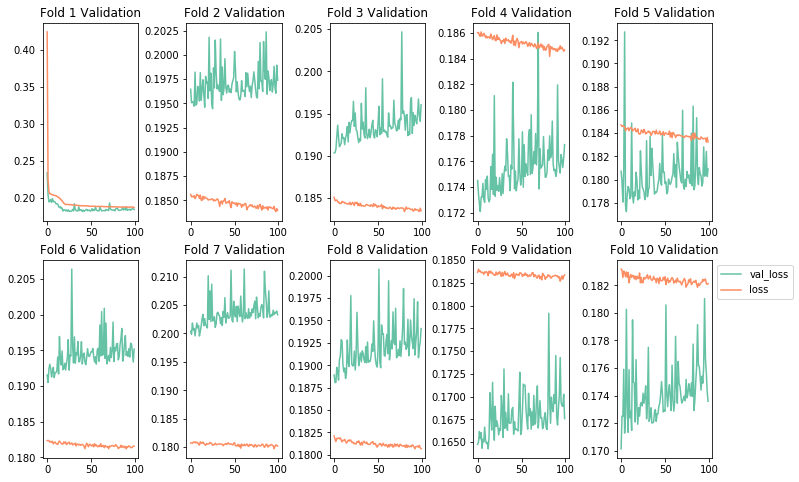

In [13]:
#Your code here; try some methods to overfit your network
now = datetime.datetime.now()

model = Sequential()
model.add(Dense(7, activation='relu', input_dim=23, kernel_initializer='normal'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(optimizer='sgd',loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model)    

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3725/3725 [==============================] - 0s 31us/step
Mean Validation Score: 0.18714019394041687
Standard Deviation of Validation Scores: 0.010455539991840665
Time Elapsed: 0:35:47.579341


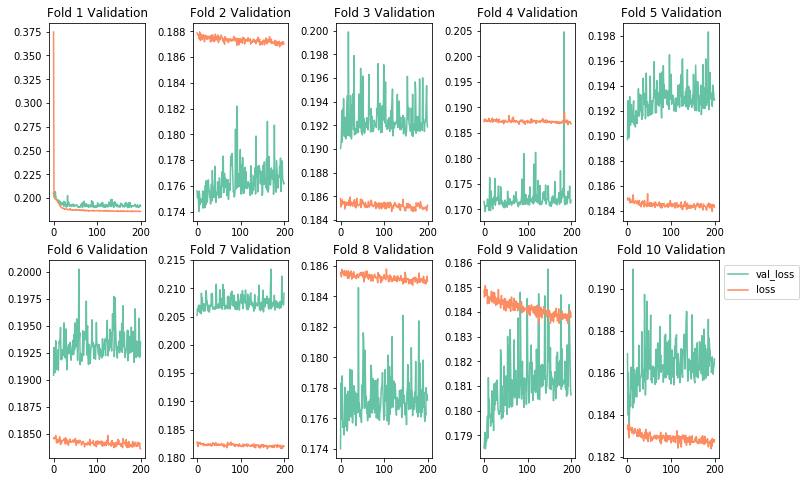

In [14]:
#Your code here; try some methods to overfit your network
now = datetime.datetime.now()

model = Sequential()
model.add(Dense(7, activation='relu', input_dim=23, kernel_initializer='normal'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(optimizer='sgd',loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=200)    

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

## Regularizing the Model to Achieve Balance  

Now that you have a powerful model (albeit an overfit one), we can now increase the generalization of the model by using some of the regularization techniques we discussed. Some options you have to try include:  
* Adding dropout
* Adding L1/L2 regularization
* Altering the layer architecture (add or remove layers similar to above)  

This process will be constrained by time and resources. Be sure to test at least 2 different methodologies, such as dropout and L2 regularization. If you have the time, feel free to continue experimenting.

Notes: 

3725/3725 [==============================] - 0s 22us/step
Mean Validation Score: 0.19556929291625086
Standard Deviation of Validation Scores: 0.01749041178711638
Time Elapsed: 0:13:17.870123


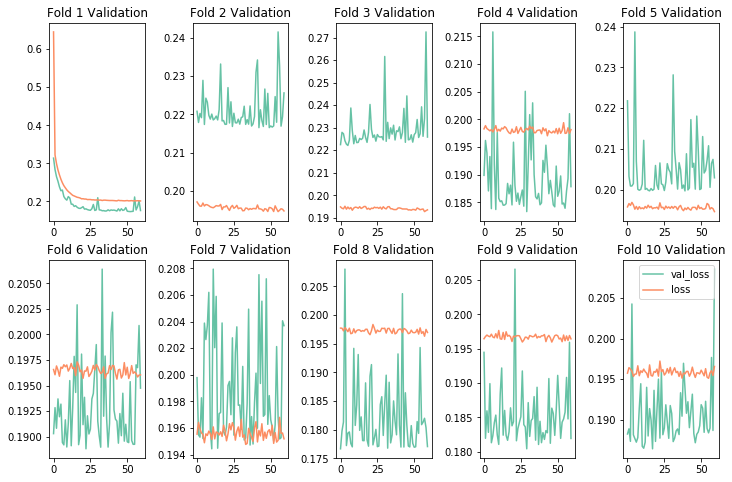

In [17]:
from keras import regularizers

#Your code here; try some regularization or other methods to tune your network
now = datetime.datetime.now()

model = Sequential()
model.add(Dense(7, activation='relu', input_dim=23, kernel_initializer='normal'))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(optimizer='sgd',loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=60)    

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

W0807 17:55:12.656574 140736270398336 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


3725/3725 [==============================] - 0s 24us/step
Mean Validation Score: 0.2760508182283269
Standard Deviation of Validation Scores: 0.026833821643114097
Time Elapsed: 0:17:35.632868


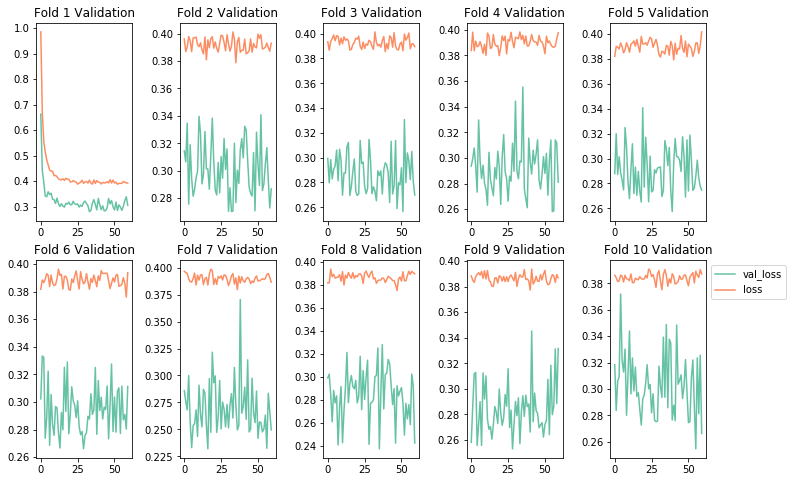

In [18]:
#Your code here; try some regularization or other methods to tune your network
from keras import layers

now = datetime.datetime.now()

model = Sequential()
model.add(Dense(7, activation='relu', input_dim=23, kernel_initializer='normal'))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(optimizer='sgd',loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=60)    

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

3725/3725 [==============================] - 0s 25us/step
Mean Validation Score: 0.4237891651283655
Standard Deviation of Validation Scores: 0.08008256538752145
Time Elapsed: 0:24:31.323990


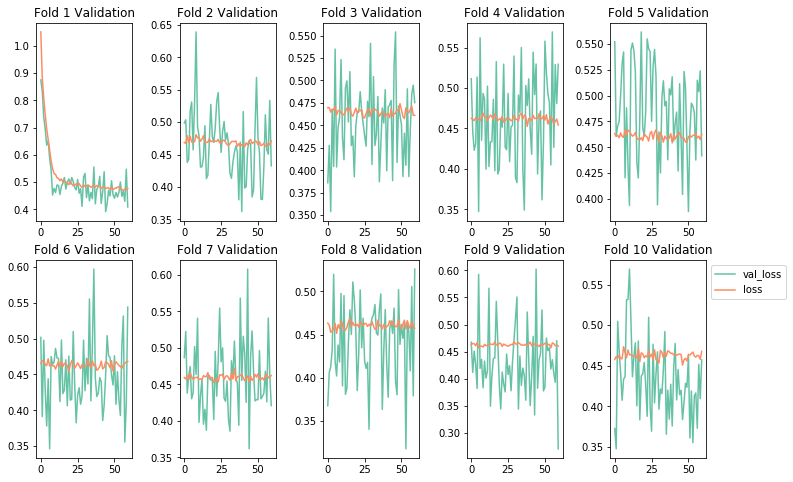

In [19]:
#Your code here; try some regularization or other methods to tune your network
now = datetime.datetime.now()

model = Sequential()
model.add(Dense(7, activation='relu', input_dim=23, kernel_initializer='normal'))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(optimizer='sgd',loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=60)    

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

## Final Evaluation

Now that you have selected a network architecture, tested various regularization procedures and tuned hyperparameters via a validation methodology, it is time to evaluate your finalized model once and for all. Fit the model using all of the training and validation data using the architecture and hyperparameters that were most effective in your expirements above. Afterwards, measure the overall performance on the hold-out test data which has been left untouched (and hasn't leaked any data into the modelling process)!

In [26]:
#Your code here; final model training on entire training set followed by evaluation on hold-out data
now = datetime.datetime.now()


model = Sequential()
model.add(Dense(7, input_dim=23, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

hist = model.fit(X_train, y_train, batch_size=32, epochs=100)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

Epoch 1/100
37254/37254 [==============================] - 3s 82us/step - loss: 0.5527 - mean_squared_error: 0.4315
Epoch 2/100
37254/37254 [==============================] - 2s 48us/step - loss: 0.3061 - mean_squared_error: 0.2058
Epoch 3/100
37254/37254 [==============================] - 2s 53us/step - loss: 0.2846 - mean_squared_error: 0.2029
Epoch 4/100
37254/37254 [==============================] - 2s 53us/step - loss: 0.2686 - mean_squared_error: 0.2016
Epoch 5/100
37254/37254 [==============================] - 2s 47us/step - loss: 0.2563 - mean_squared_error: 0.2010
Epoch 6/100
37254/37254 [==============================] - 2s 42us/step - loss: 0.2461 - mean_squared_error: 0.2001
Epoch 7/100
37254/37254 [==============================] - 2s 47us/step - loss: 0.2384 - mean_squared_error: 0.1997
Epoch 8/100
37254/37254 [==============================] - 2s 42us/step - loss: 0.2321 - mean_squared_error: 0.1993
Epoch 9/100
37254/37254 [==============================] - 2s 41us/step 

37254/37254 [==============================] - 2s 41us/step - loss: 0.1985 - mean_squared_error: 0.1920
Epoch 71/100
37254/37254 [==============================] - 2s 41us/step - loss: 0.1987 - mean_squared_error: 0.1922
Epoch 72/100
37254/37254 [==============================] - 2s 41us/step - loss: 0.1984 - mean_squared_error: 0.1918
Epoch 73/100
37254/37254 [==============================] - 2s 41us/step - loss: 0.1982 - mean_squared_error: 0.1917
Epoch 74/100
37254/37254 [==============================] - 2s 40us/step - loss: 0.1980 - mean_squared_error: 0.1916
Epoch 75/100
37254/37254 [==============================] - 2s 41us/step - loss: 0.1986 - mean_squared_error: 0.1921
Epoch 76/100
37254/37254 [==============================] - 2s 54us/step - loss: 0.1985 - mean_squared_error: 0.1920
Epoch 77/100
37254/37254 [==============================] - 3s 77us/step - loss: 0.1984 - mean_squared_error: 0.1919
Epoch 78/100
37254/37254 [==============================] - 2s 42us/step - lo

In [27]:
model.evaluate(X_test, y_test)

4140/4140 [==============================] - 1s 186us/step


[0.18033946132026432, 0.174251942012621]

In [24]:
now = datetime.datetime.now()

model = Sequential()
model.add(Dense(7, activation='relu', input_dim=23, kernel_initializer='normal'))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model.add(layers.Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(optimizer='sgd',loss='mse',metrics=['mse'])

hist = model.fit(X_train, y_train, batch_size=32, epochs=60)

later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)

Epoch 1/60
37254/37254 [==============================] - 5s 127us/step - loss: 1.0093 - mean_squared_error: 0.6619
Epoch 2/60
37254/37254 [==============================] - 4s 94us/step - loss: 0.7029 - mean_squared_error: 0.4127
Epoch 3/60
37254/37254 [==============================] - 3s 91us/step - loss: 0.6206 - mean_squared_error: 0.3813
Epoch 4/60
37254/37254 [==============================] - 2s 61us/step - loss: 0.5658 - mean_squared_error: 0.3686
Epoch 5/60
37254/37254 [==============================] - 2s 58us/step - loss: 0.5241 - mean_squared_error: 0.3645
Epoch 6/60
37254/37254 [==============================] - 2s 67us/step - loss: 0.4884 - mean_squared_error: 0.3592
Epoch 7/60
37254/37254 [==============================] - 3s 90us/step - loss: 0.4631 - mean_squared_error: 0.3567
Epoch 8/60
37254/37254 [==============================] - 3s 78us/step - loss: 0.4503 - mean_squared_error: 0.3602
Epoch 9/60
37254/37254 [==============================] - 2s 58us/step - loss: 

In [25]:
model.evaluate(X_test, y_test)

4140/4140 [==============================] - 1s 191us/step


[0.3578579466412033, 0.3007659397551403]

## Additional Resources

https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
https://www.springboard.com/blog/free-public-data-sets-data-science-project/

## Summary

In this lab, we investigated some data from *The Lending Club* in a complete data science pipeline regarding neural networks. We began with reserving a hold-out set for testing which never was touched during the modeling phase. From there, we implemented a k-fold cross validation methodology in order to assess an initial baseline model and various regularization methods. From here, we'll begin to investigate other neural network architectures such as CNNs.